# iv. unpacking 'selecting_rabs_from_poly'
to do :
- update function **selecting_rabs_from_poly** to create a custom area threshold with *85 percentile* as its default
- adjust the way we are selecting the adjacent polygons


In [1]:
import numpy as np
import geopandas as gpd
from shapely.ops import polygonize
import matplotlib.pyplot as plt
import folium
import momepy as mm # outputs a 'TqdmWarning'

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#only for development - to stop DeprecationWarnings from poping up
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# A value is trying to be set on a copy of a slice from a DataFrame.

<AxesSubplot:>

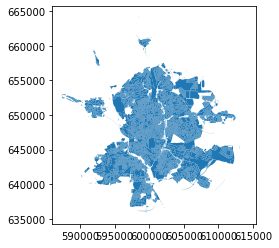

In [4]:
#loading data from file
mad = gpd.read_file('/Users/gregoriomaya/Desktop/GSoc_2022/gsoc2022_network_simpl/data/madrid2062.gpkg')
mad.set_index(['u', 'v', 'key'], inplace=True)


mad_polys = polygonize(mad.geometry)
mad_polys = gpd.GeoDataFrame(geometry = [g for g in mad_polys], crs= mad.crs)
mad_polys.plot()

# 1. EXCLUDING the large polygons

In [9]:
gdf = mad_polys #dummy step just to imitate function names
# loading data
# calculate parameters
gdf["area"] = gdf.geometry.area
gdf["circom"] = mm.CircularCompactness(gdf, "area").series

#selecting round about polygons based on compactness
rab = gdf[gdf.circom > 0.7]
print('RABS before excluding: ', len(rab) )
rab.head(3)

RABS before excluding:  692


,geometry,area,circom
26,"POLYGON ((607717.202 647660.853, 607713.722 64...",9791.985128,0.945734
33,"POLYGON ((606720.853 648289.500, 606726.488 64...",14631.053756,0.989725
123,"POLYGON ((606900.821 647174.729, 606903.771 64...",6302.624123,0.746885


In [14]:
a_perc_th = 0.85
area_threshold = gdf.area.quantile(a_perc_th)

# exclude those above the area threshold
rab = rab[rab.area < area_threshold]
print('RABS after excluding: ', len(rab) )

RABS after excluding:  689


**Done: implemented in function!**

# 2. Better selecting adjacent polys

In [17]:
# the current method is :
rab = gpd.sjoin(gdf, rab, predicate = 'intersects')
rab = rab[rab.area_right >= rab.area_left] #the ones smaller than itself

#rab = rab[['geometry', 'index_right']] #only keeping necesary columns
adjacent_count = len(rab[rab.index != rab.index_right])
print('Adjacent polygons selected: ', adjacent_count)

Adjacent polygons selected:  799


<AxesSubplot:title={'center':'area_left'}, xlabel='[adjacent_polys]'>

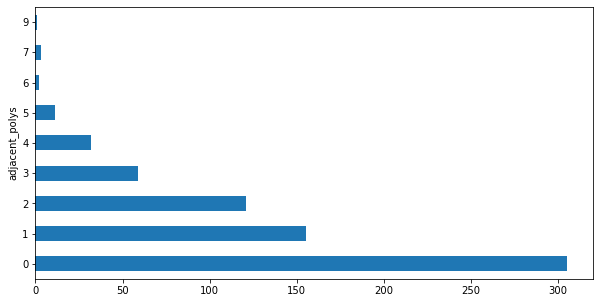

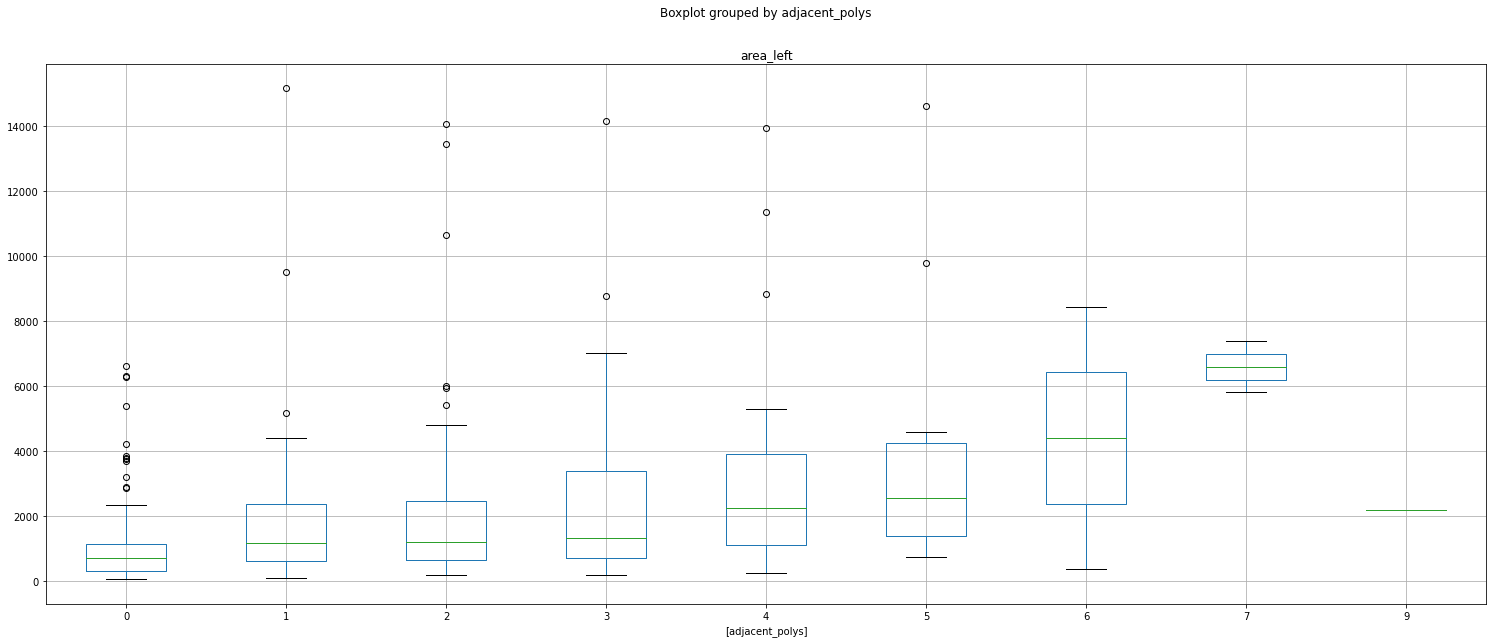

In [22]:
#distribution per number of adjacent polys
or_rabs = rab[rab.index == rab.index_right]
or_rabs['adjacent_polys'] = rab.groupby('index_right')['index_right'].count()-1


#plotting
s = or_rabs.groupby('adjacent_polys')['index_right'].count()
s.plot.barh(figsize = (10,5))

or_rabs.boxplot(figsize = (25,10),column=['area_left'], by = ['adjacent_polys'])

<AxesSubplot:>

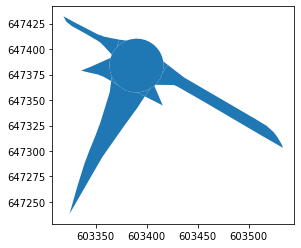

In [44]:
#selecting the set with multiple adjacent polys
multi_idx = or_rabs[or_rabs.adjacent_polys == 9].index[0]
rab[rab.index_right == multi_idx ].plot()

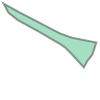

In [71]:
rab[rab.index_right == multi_idx].iloc[4].geometry

In [52]:
#need to create a for loop for each original RAB (index == index_right) 
minx, miny, maxx, maxy = rab.loc[multi_idx].geometry.bounds 
rab_diameter = maxx - minx
print('DIAMETER OF (demo) RAB\n',rab_diameter)

DIAMETER OF (demo) RAB
 53.01150238804985


In [74]:
base_rab = rab.loc[multi_idx].geometry
h_dist = base_rab.hausdorff_distance(rab[rab.index_right == multi_idx].iloc[4].geometry)
h_dist

59.99241263408641

## imitating function to add a more nuanced selection

In [85]:
#selecting round about polygons based on compactness
rab = gdf[gdf.circom > 0.7] # originally dynamic in the function
#exclude those above the area threshold
area_threshold = gdf.area.quantile(0.85) # originally dynamic in the function
rab = rab[rab.area < area_threshold]

#if include_adjacent == True :
#selecting the adjacent areas that are of smaller than itself
rab_adj = gpd.sjoin(gdf, rab, predicate = 'intersects')
rab_adj = rab_adj[rab_adj.area_right >= rab_adj.area_left]
rab_adj.tail()

,geometry,area_left,circom_left,index_right,area_right,circom_right
15810,"POLYGON ((605353.740 656290.203, 605351.886 65...",88.837465,0.211953,15809,331.767969,0.901586
15811,"POLYGON ((605450.314 656422.762, 605450.811 65...",693.528500,0.932036,15811,693.528500,0.932036
15820,"POLYGON ((599310.998 656796.065, 599307.324 65...",565.396701,0.977952,15820,565.396701,0.977952
15848,"POLYGON ((602865.024 656746.199, 602869.344 65...",1608.790869,0.977934,15848,1608.790869,0.977934
15852,"POLYGON ((592098.635 643109.424, 592098.226 64...",257.479120,0.970399,15852,257.479120,0.970399


In [132]:
adj_long_polys = []
#iterate through original rabs
for i, row in rab.iterrows():
    #creating a distance (diameter) for limiting the max dist of adjacent
    minx, _ , maxx, _ = rab.loc[i].geometry.bounds 
    rab_diameter = maxx - minx
    #creating the subgroup that could be affected
    rab_group = rab_adj[rab_adj.index_right==i]
    for ii, rrow in rab_group.iterrows():
        hdist = rab.loc[i].geometry.hausdorff_distance(rrow.geometry)
        if hdist > rab_diameter :
            adj_long_polys.append(ii) #if hausdorff_distance is larger than the diameter add to list
print('Adjacent polygons that should be eliminated\n',len(adj_long_polys))

total_adj = len(rab_adj) - len(rab)
print(round( len(adj_long_polys)/total_adj*100 , 1) , '%')

Adjacent polygons that should be eliminated
 373
46.7 %


In [135]:
rab_adj.drop(adj_long_polys, inplace= True)
len(rab_adj)

1113

### The above now needs to be implemented into the actual function for testing